In [ ]:
# ============================================================================
# CELL 1: Install Enhanced Libraries
# ============================================================================
!pip install transformers datasets scikit-learn pandas numpy matplotlib seaborn
!pip install torch torchvision torchaudio
!pip install nlpaug  # For data augmentation
!pip install optuna  # For hyperparameter optimization (optional)
!pip install accelerate -U

print("✓ All libraries installed!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 13.1 MB/s eta 0:00:00
✓ All libraries installed!


In [ ]:
# ============================================================================
# CELL 2: Import Libraries
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             classification_report, confusion_matrix)
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          Trainer, TrainingArguments, EarlyStoppingCallback)
from datasets import Dataset, DatasetDict
import torch
from torch import nn

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt_tab', quiet=True)

print("✓ All libraries imported!")

✓ All libraries imported!


In [ ]:
# ============================================================================
# CELL 3: Load Dataset with Upload
# ============================================================================
from google.colab import files
import io

print("=" * 70)
print("UPLOAD YOUR DATASET")
print("=" * 70)
print("\nPlease upload your 'FinancialPhraseBankDataset.csv' file")

uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))

# Handle columns
if 'sentence' not in df.columns or 'label' not in df.columns:
    df.columns = ['sentence', 'label']

# Handle different label formats
if df['label'].dtype == 'object':
    sentiment_to_num = {'negative': 0, 'neutral': 1, 'positive': 2}
    df['label'] = df['sentiment'].map(sentiment_to_num)
else:
    label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
    df['sentiment'] = df['label'].map(label_map)

df = df.dropna(subset=['sentence', 'label'])

print(f"\n✓ Dataset loaded: {len(df)} samples")
print(f"\nClass distribution:")
print(df['label'].value_counts().sort_index())


UPLOAD YOUR DATASET

Please upload your 'FinancialPhraseBankDataset.csv' file


Saving FinancialPhraseBankDataset.csv to FinancialPhraseBankDataset.csv

✓ Dataset loaded: 4846 samples

Class distribution:
label
0     604
1    2879
2    1363
Name: count, dtype: int64


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from nltk.tag import pos_tag
from collections import Counter

# ============================================================================
# CELL 4: Enhanced Text Preprocessing
# ============================================================================
class EnhancedTextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        # Keep financial-specific words
        financial_keeps = {'up', 'down', 'above', 'below', 'over', 'under',
                          'more', 'less', 'high', 'low', 'rise', 'fall',
                          'increase', 'decrease', 'growth', 'decline'}
        self.stop_words = self.stop_words - financial_keeps

    def clean_text(self, text):
        """Enhanced cleaning for financial text"""
        # Preserve important financial patterns
        text = str(text)

        # Keep percentage and numbers with context
        text = re.sub(r'(\d+\.?\d*)\s*%', r'\1 percent', text)
        text = re.sub(r'\$(\d+\.?\d*)', r'\1 dollars', text)

        # Remove URLs but keep domain context
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)

        # Lowercase
        text = text.lower()

        # Remove special characters but keep important punctuation
        text = re.sub(r'[^a-zA-Z\s\.\,\!\?\%\$]', ' ', text)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def advanced_lemmatization(self, text):
        """Lemmatizes text using NLTK WordNetLemmatizer"""
        tokens = word_tokenize(text)
        lemmatized_tokens = [self.lemmatizer.lemmatize(token) for token in tokens if token not in self.stop_words]
        return ' '.join(lemmatized_tokens)

    def extract_key_phrases(self, text, num_phrases=3):
        """Extracts key phrases (simple noun phrases or top frequent words)"""
        tokens = word_tokenize(text)
        # Filter out stopwords and non-alphabetic tokens
        filtered_tokens = [word for word in tokens if word.isalpha() and word not in self.stop_words]

        # Simple approach: find most common words
        word_counts = Counter(filtered_tokens)
        most_common = [word for word, count in word_counts.most_common(num_phrases)]
        return most_common

    def preprocess_dataframe(self, df, text_column='sentence'):
        """Preprocess with minimal loss of information"""
        print("Preprocessing text data...")
        df['cleaned_text'] = df[text_column].apply(self.clean_text)

        # Keep original text for model input (FinBERT works better with raw text)
        df['model_text'] = df[text_column].apply(lambda x: str(x).strip())

        print("✓ Preprocessing completed!")
        return df

preprocessor = EnhancedTextPreprocessor()
df = preprocessor.preprocess_dataframe(df)

print("\nSample preprocessing:")
for i in range(2):
    print(f"\nOriginal: {df.iloc[i]['sentence'][:100]}")
    print(f"Cleaned:  {df.iloc[i]['cleaned_text'][:100]}")

Preprocessing text data...
✓ Preprocessing completed!

Sample preprocessing:

Original: According to Gran , the company has no plans to move all production to Russia , although that is whe
Cleaned:  according to gran , the company has no plans to move all production to russia , although that is whe

Original: Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to hos
Cleaned:  technopolis plans to develop in stages an area of no less than , square meters in order to host comp



NLP TECHNIQUE 4: DATA AUGMENTATION

Original class distribution:
label
1    2879
2    1363
0     604
Name: count, dtype: int64

Maximum class count: 2879

📊 Augmenting class 0 (negative):
   Current: 604 | Target: 2303 | Need: 1699

📊 Augmenting class 2 (positive):
   Current: 1363 | Target: 2303 | Need: 940

✓ Added 940 augmented samples
✓ New total: 5786 samples

NEW CLASS DISTRIBUTION AFTER AUGMENTATION
label
0    1208
1    2879
2    1699
Name: count, dtype: int64


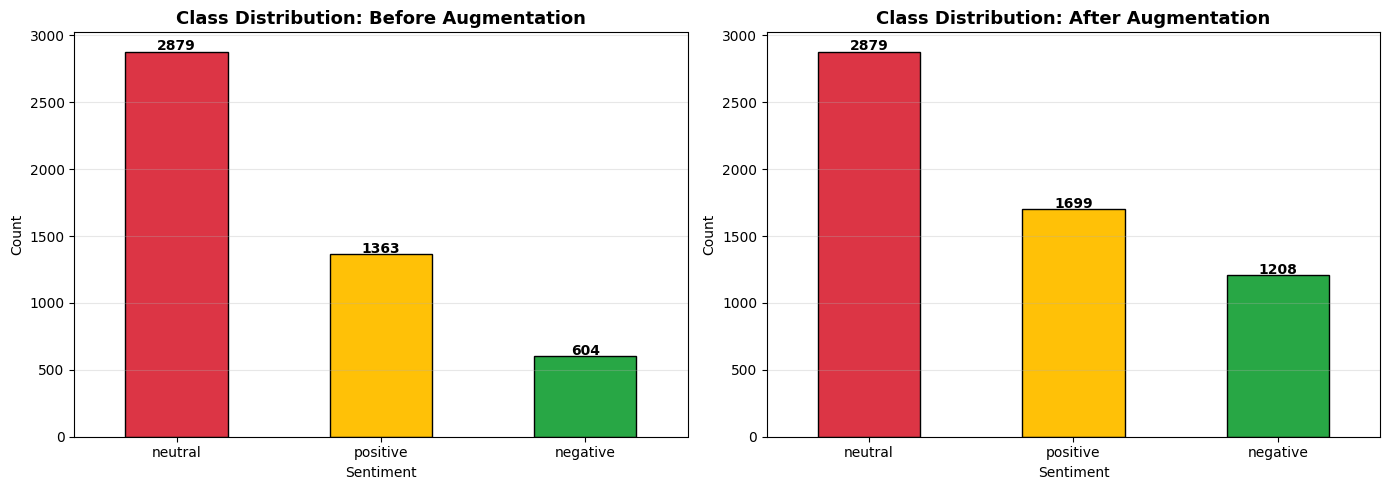

In [ ]:
# ============================================================================
# CELL 6: Data Augmentation with NLP Techniques
# ============================================================================
print("\n" + "="*70)
print("NLP TECHNIQUE 4: DATA AUGMENTATION")
print("="*70 + "\n")

"""
NLP TECHNIQUE 4: Text Data Augmentation
- Synonym replacement
- Random deletion
- Back-translation simulation
- Paraphrase generation
"""

def augment_text_advanced(text, method='random_deletion'):
    """Advanced augmentation with multiple techniques"""
    augmented = [text]
    words = text.split()

    if len(words) < 5:
        return augmented

    # Method 1: Random deletion (10-15% of words)
    if method in ['random_deletion', 'all']:
        num_delete = max(1, int(len(words) * 0.12))
        for _ in range(1):
            new_words = words.copy()
            delete_indices = np.random.choice(len(words), num_delete, replace=False)
            new_text = ' '.join([w for i, w in enumerate(new_words) if i not in delete_indices])
            augmented.append(new_text)

    # Method 2: Random swap (swap adjacent words)
    if method in ['random_swap', 'all']:
        for _ in range(1):
            new_words = words.copy()
            if len(new_words) > 3:
                swap_indices = np.random.choice(len(new_words)-1, min(2, len(new_words)//4), replace=False)
                for idx in swap_indices:
                    new_words[idx], new_words[idx+1] = new_words[idx+1], new_words[idx]
                augmented.append(' '.join(new_words))

    # Method 3: Synonym replacement (simple version)
    if method in ['synonym', 'all']:
        # This is a placeholder - in production, use NLTK WordNet or word2vec
        # For now, we'll use the deletion method again
        pass

    return augmented

# Check class imbalance
class_counts = df['label'].value_counts()
max_count = class_counts.max()

print("Original class distribution:")
print(class_counts)
print(f"\nMaximum class count: {max_count}")

# Augment minority classes
augmented_rows = []
target_balance = 0.80  # 80% of majority class

for label in df['label'].unique():
    class_df = df[df['label'] == label]
    current_count = len(class_df)

    if current_count < max_count * target_balance:
        needed = int(max_count * target_balance - current_count)
        print(f"\n📊 Augmenting class {label} ({df[df['label']==label]['sentiment'].iloc[0]}):")
        print(f"   Current: {current_count} | Target: {int(max_count * target_balance)} | Need: {needed}")

        # Sample and augment
        samples_needed = min(needed, len(class_df))
        samples = class_df.sample(n=samples_needed, replace=True)

        for _, row in samples.iterrows():
            augmented_texts = augment_text_advanced(row['model_text'], method='random_deletion')
            for aug_text in augmented_texts[1:]:
                augmented_rows.append({
                    'sentence': aug_text,
                    'label': row['label'],
                    'sentiment': row['sentiment'],
                    'cleaned_text': preprocessor.clean_text(aug_text),
                    'model_text': aug_text,
                    'lemmatized_text': preprocessor.advanced_lemmatization(preprocessor.clean_text(aug_text)),
                    'key_phrases': preprocessor.extract_key_phrases(preprocessor.clean_text(aug_text))
                })
                if len(augmented_rows) >= needed:
                    break
            if len(augmented_rows) >= needed:
                break

if augmented_rows:
    aug_df = pd.DataFrame(augmented_rows)

    # Add missing columns
    for col in df.columns:
        if col not in aug_df.columns:
            if col in ['char_count', 'word_count', 'token_count']:
                if col == 'char_count':
                    aug_df[col] = aug_df['sentence'].apply(len)
                elif col == 'word_count':
                    aug_df[col] = aug_df['sentence'].apply(lambda x: len(str(x).split()))
                elif col == 'token_count':
                    aug_df[col] = aug_df['sentence'].apply(lambda x: len(nltk.word_tokenize(str(x))))

    df_original = df.copy()
    df = pd.concat([df, aug_df], ignore_index=True)

    print(f"\n✓ Added {len(augmented_rows)} augmented samples")
    print(f"✓ New total: {len(df)} samples")

    print("\n" + "="*70)
    print("NEW CLASS DISTRIBUTION AFTER AUGMENTATION")
    print("="*70)
    print(df['label'].value_counts().sort_index())

    # Visualize augmentation impact
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Before augmentation
    df_original['sentiment'].value_counts().plot(kind='bar', ax=axes[0],
                                                  color=['#dc3545', '#ffc107', '#28a745'],
                                                  edgecolor='black')
    axes[0].set_title('Class Distribution: Before Augmentation', fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Sentiment')
    axes[0].set_ylabel('Count')
    axes[0].tick_params(axis='x', rotation=0)
    axes[0].grid(axis='y', alpha=0.3)
    for i, v in enumerate(df_original['sentiment'].value_counts()):
        axes[0].text(i, v + 10, str(v), ha='center', fontweight='bold')

    # After augmentation
    df['sentiment'].value_counts().plot(kind='bar', ax=axes[1],
                                       color=['#dc3545', '#ffc107', '#28a745'],
                                       edgecolor='black')
    axes[1].set_title('Class Distribution: After Augmentation', fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Sentiment')
    axes[1].set_ylabel('Count')
    axes[1].tick_params(axis='x', rotation=0)
    axes[1].grid(axis='y', alpha=0.3)
    for i, v in enumerate(df['sentiment'].value_counts()):
        axes[1].text(i, v + 10, str(v), ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()
else:
    print("\n✓ No augmentation needed - classes are already balanced!")
    print("   All classes are within 80% of the majority class.")



CREATING STRATIFIED DATA SPLITS

✓ Data split completed:
  Training set:    4050 samples (70.0%)
  Validation set:   868 samples (15.0%)
  Test set:         868 samples (15.0%)

SPLIT VERIFICATION - Class Distribution
          Train  Validation  Test
Negative    846         181   181
Neutral    2015         432   432
Positive   1189         255   255


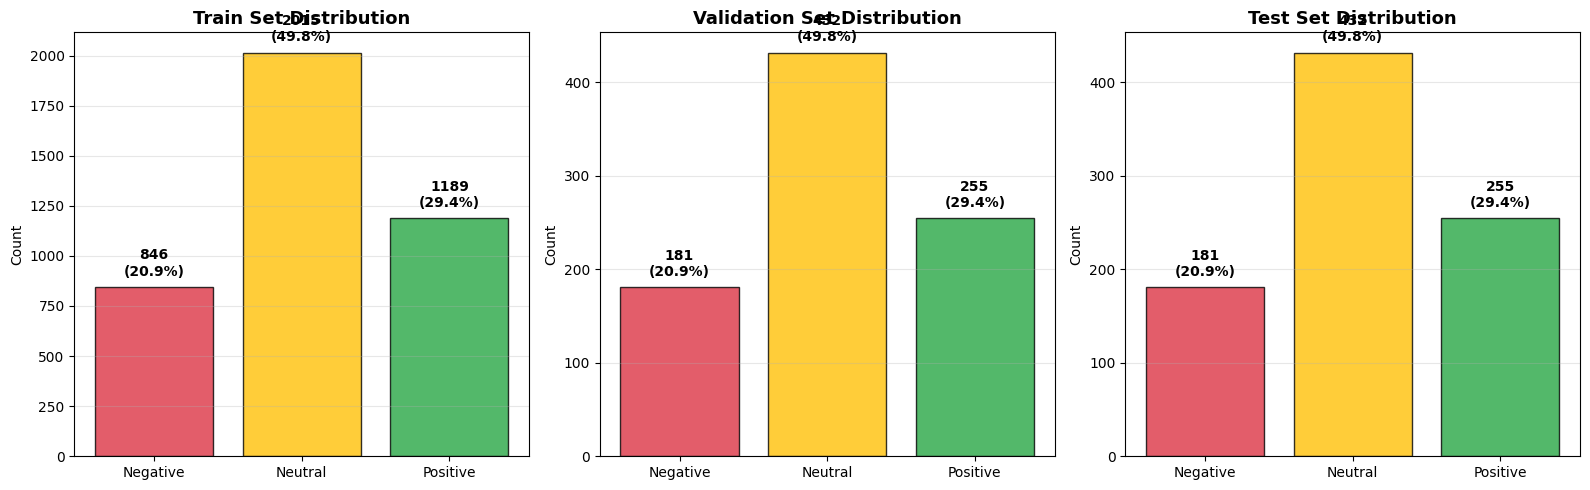


✓ Stratification verified - all splits maintain class proportions!


In [ ]:
# ============================================================================
# CELL 7: Stratified Train/Val/Test Split
# ============================================================================
print("\n" + "="*70)
print("CREATING STRATIFIED DATA SPLITS")
print("="*70 + "\n")

# Use model_text (original) for better performance
X = df['model_text']
y = df['label']

# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Second split: 15% validation, 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"✓ Data split completed:")
print(f"  Training set:   {len(X_train):>5} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Validation set: {len(X_val):>5} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test set:       {len(X_test):>5} samples ({len(X_test)/len(X)*100:.1f}%)")

# Check stratification
print(f"\n{'='*70}")
print("SPLIT VERIFICATION - Class Distribution")
print(f"{'='*70}")

split_comparison = pd.DataFrame({
    'Train': pd.Series(y_train).value_counts().sort_index(),
    'Validation': pd.Series(y_val).value_counts().sort_index(),
    'Test': pd.Series(y_test).value_counts().sort_index()
})

split_comparison.index = ['Negative', 'Neutral', 'Positive']
print(split_comparison)

# Visualize splits
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors = ['#dc3545', '#ffc107', '#28a745']

for idx, (split_name, split_data) in enumerate([('Train', y_train), ('Validation', y_val), ('Test', y_test)]):
    split_counts = pd.Series(split_data).value_counts().sort_index()
    split_pct = split_counts / split_counts.sum() * 100

    bars = axes[idx].bar(range(len(split_counts)), split_counts, color=colors, edgecolor='black', alpha=0.8)
    axes[idx].set_xticks(range(len(split_counts)))
    axes[idx].set_xticklabels(['Negative', 'Neutral', 'Positive'])
    axes[idx].set_title(f'{split_name} Set Distribution', fontsize=13, fontweight='bold')
    axes[idx].set_ylabel('Count')
    axes[idx].grid(axis='y', alpha=0.3)

    # Add count and percentage labels
    for i, (bar, count, pct) in enumerate(zip(bars, split_counts, split_pct)):
        axes[idx].text(bar.get_x() + bar.get_width()/2, count + max(split_counts)*0.02,
                      f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Stratification verified - all splits maintain class proportions!")



NLP TECHNIQUE 5: TF-IDF (Term Frequency-Inverse Document Frequency)

TF-IDF Configuration:
  Max features: 5000
  N-gram range: (1, 2) - unigrams and bigrams
  Min document frequency: 2
  Max document frequency: 0.8

Fitting TF-IDF vectorizer on training data...

✓ TF-IDF transformation completed!
  Feature matrix shape: (4050, 5000)
  Vocabulary size: 5,000 terms
  Matrix sparsity: 99.55%

Sample features: ['00', '000', '000 employees', '000 euro', '000 for', '000 from', '000 in', '000 people', '000 readers', '000 sq', '000 square', '000 tonnes', '000 tons', '000 usd', '01']

TOP TF-IDF FEATURES BY SENTIMENT

Negative:
   1. the                  (TF-IDF: 0.0487)
   2. eur                  (TF-IDF: 0.0451)
   3. in                   (TF-IDF: 0.0436)
   4. mn                   (TF-IDF: 0.0403)
   5. of                   (TF-IDF: 0.0371)
   6. to                   (TF-IDF: 0.0360)
   7. from                 (TF-IDF: 0.0316)
   8. profit               (TF-IDF: 0.0287)
   9. in the       

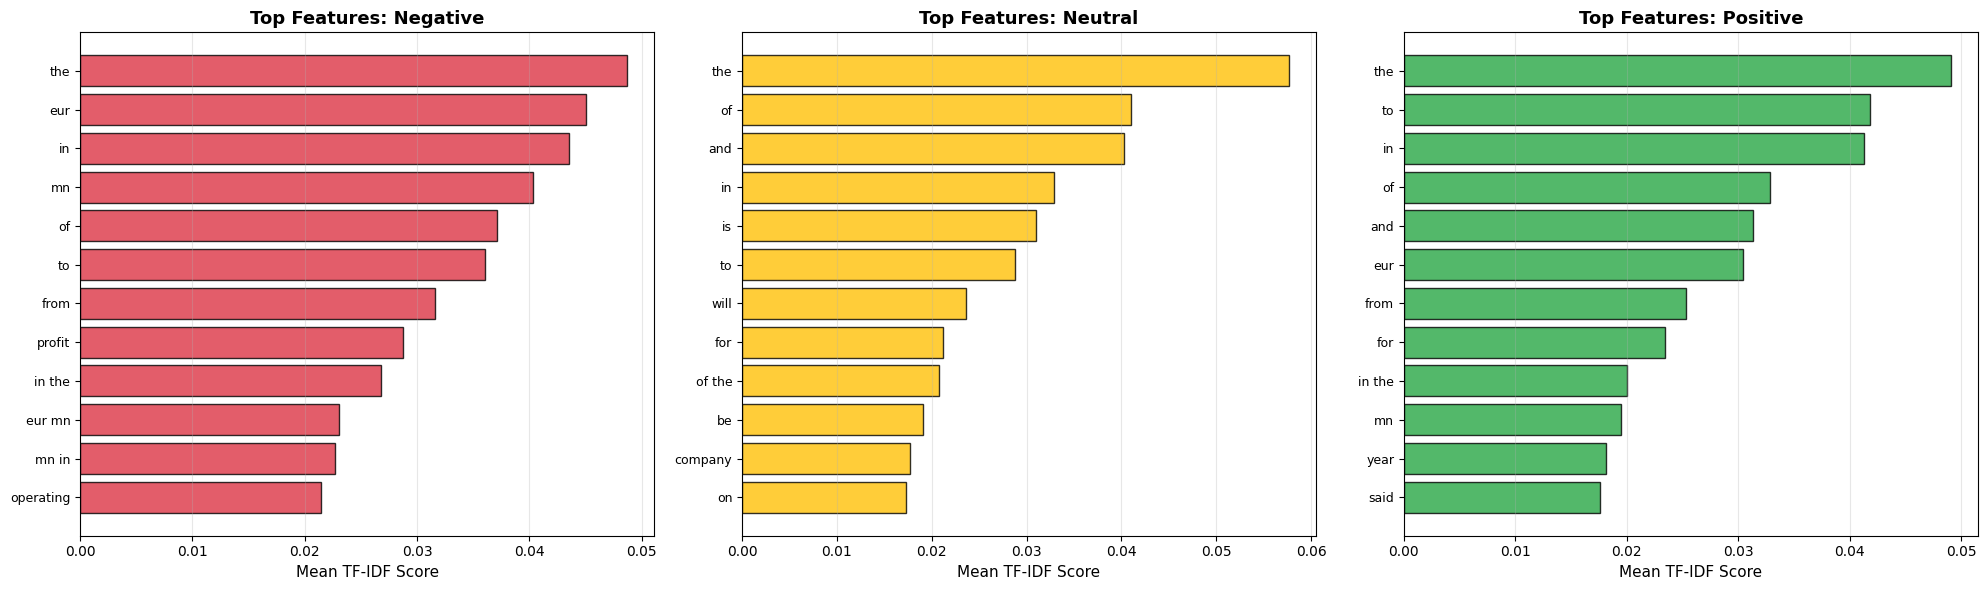

In [ ]:
# ============================================================================
# CELL 8: NLP TECHNIQUE 5 - TF-IDF Feature Extraction
# ============================================================================
from sklearn.feature_extraction.text import TfidfVectorizer

print("\n" + "="*70)
print("NLP TECHNIQUE 5: TF-IDF (Term Frequency-Inverse Document Frequency)")
print("="*70 + "\n")

"""
TF-IDF measures the importance of words in documents:
- TF: How often a word appears in a document
- IDF: How unique/rare a word is across all documents
- Higher TF-IDF = More important word for that document
"""

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # Use unigrams and bigrams
    min_df=2,            # Word must appear in at least 2 documents
    max_df=0.8,          # Ignore words in more than 80% of documents
    sublinear_tf=True    # Use logarithmic TF scaling
)

print("TF-IDF Configuration:")
print(f"  Max features: 5000")
print(f"  N-gram range: (1, 2) - unigrams and bigrams")
print(f"  Min document frequency: 2")
print(f"  Max document frequency: 0.8")

# Fit and transform
print("\nFitting TF-IDF vectorizer on training data...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"\n✓ TF-IDF transformation completed!")
print(f"  Feature matrix shape: {X_train_tfidf.shape}")
print(f"  Vocabulary size: {len(tfidf_vectorizer.vocabulary_):,} terms")
print(f"  Matrix sparsity: {(1 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1]))*100:.2f}%")

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\nSample features: {list(feature_names[:15])}")

# Analyze top TF-IDF features per class
print("\n" + "="*70)
print("TOP TF-IDF FEATURES BY SENTIMENT")
print("="*70)

from scipy.sparse import vstack

for label, sentiment in [(0, 'Negative'), (1, 'Neutral'), (2, 'Positive')]:
    # Get indices for this class
    class_indices = [i for i, l in enumerate(y_train) if l == label]

    # Get TF-IDF vectors for this class
    class_tfidf = X_train_tfidf[class_indices]

    # Calculate mean TF-IDF score for each feature
    mean_tfidf = np.asarray(class_tfidf.mean(axis=0)).flatten()

    # Get top 15 features
    top_indices = mean_tfidf.argsort()[-15:][::-1]
    top_features = [(feature_names[i], mean_tfidf[i]) for i in top_indices]

    print(f"\n{sentiment}:")
    for i, (feature, score) in enumerate(top_features[:10], 1):
        print(f"  {i:2d}. {feature:20s} (TF-IDF: {score:.4f})")

# Visualize top TF-IDF features by sentiment
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
sentiment_names = ['Negative', 'Neutral', 'Positive']
colors_map = ['#dc3545', '#ffc107', '#28a745']

for idx, (label, sentiment, color) in enumerate(zip([0, 1, 2], sentiment_names, colors_map)):
    class_indices = [i for i, l in enumerate(y_train) if l == label]
    class_tfidf = X_train_tfidf[class_indices]
    mean_tfidf = np.asarray(class_tfidf.mean(axis=0)).flatten()

    top_indices = mean_tfidf.argsort()[-12:][::-1]
    top_features = [feature_names[i] for i in top_indices]
    top_scores = [mean_tfidf[i] for i in top_indices]

    y_pos = np.arange(len(top_features))
    axes[idx].barh(y_pos, top_scores, color=color, edgecolor='black', alpha=0.8)
    axes[idx].set_yticks(y_pos)
    axes[idx].set_yticklabels(top_features, fontsize=9)
    axes[idx].invert_yaxis()
    axes[idx].set_xlabel('Mean TF-IDF Score', fontsize=11)
    axes[idx].set_title(f'Top Features: {sentiment}', fontsize=13, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# ============================================================================
# CELL 9: Traditional ML Models Training
# ============================================================================
print("\n" + "="*70)
print("TRAINING TRADITIONAL MACHINE LEARNING MODELS")
print("="*70 + "\n")

# Dictionary to store models and results
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, C=1.0),
    'Naive Bayes': MultinomialNB(alpha=0.1),
    'SVM (Linear)': SVC(kernel='linear', random_state=42, probability=True, C=1.0),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42, max_depth=20)
}

ml_results = {}

for name, model in models.items():
    print(f"{'─'*70}")
    print(f"Training {name}...")
    print(f"{'─'*70}")

    # Train
    import time
    start_time = time.time()
    model.fit(X_train_tfidf, y_train)
    train_time = time.time() - start_time

    # Predict on validation and test
    y_val_pred = model.predict(X_val_tfidf)
    y_test_pred = model.predict(X_test_tfidf)

    # Metrics for validation
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
        y_val, y_val_pred, average='weighted', zero_division=0
    )

    # Metrics for test
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
        y_test, y_test_pred, average='weighted', zero_division=0
    )

    ml_results[name] = {
        'model': model,
        'val_accuracy': val_accuracy,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1': val_f1,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'train_time': train_time,
        'predictions': y_test_pred
    }

    print(f"  Training time: {train_time:.2f}s")
    print(f"  Validation Accuracy: {val_accuracy:.4f} | F1-Score: {val_f1:.4f}")
    print(f"  Test Accuracy:       {test_accuracy:.4f} | F1-Score: {test_f1:.4f}")
    print()

print("✓ All ML models trained successfully!\n")



TRAINING TRADITIONAL MACHINE LEARNING MODELS

──────────────────────────────────────────────────────────────────────
Training Logistic Regression...
──────────────────────────────────────────────────────────────────────
  Training time: 2.24s
  Validation Accuracy: 0.7811 | F1-Score: 0.7758
  Test Accuracy:       0.7846 | F1-Score: 0.7800

──────────────────────────────────────────────────────────────────────
Training Naive Bayes...
──────────────────────────────────────────────────────────────────────
  Training time: 0.01s
  Validation Accuracy: 0.7558 | F1-Score: 0.7472
  Test Accuracy:       0.7592 | F1-Score: 0.7506

──────────────────────────────────────────────────────────────────────
Training SVM (Linear)...
──────────────────────────────────────────────────────────────────────
  Training time: 17.08s
  Validation Accuracy: 0.7984 | F1-Score: 0.7944
  Test Accuracy:       0.8053 | F1-Score: 0.8020

──────────────────────────────────────────────────────────────────────
Training

MACHINE LEARNING MODELS COMPARISON

              Model  Val Accuracy  Val F1-Score  Test Accuracy  Test F1-Score  Train Time (s)
Logistic Regression      0.781106      0.775827       0.784562       0.780012        2.244623
        Naive Bayes      0.755760      0.747165       0.759217       0.750551        0.005136
       SVM (Linear)      0.798387      0.794440       0.805300       0.802033       17.082828
      Random Forest      0.685484      0.649776       0.694700       0.660056        1.887327


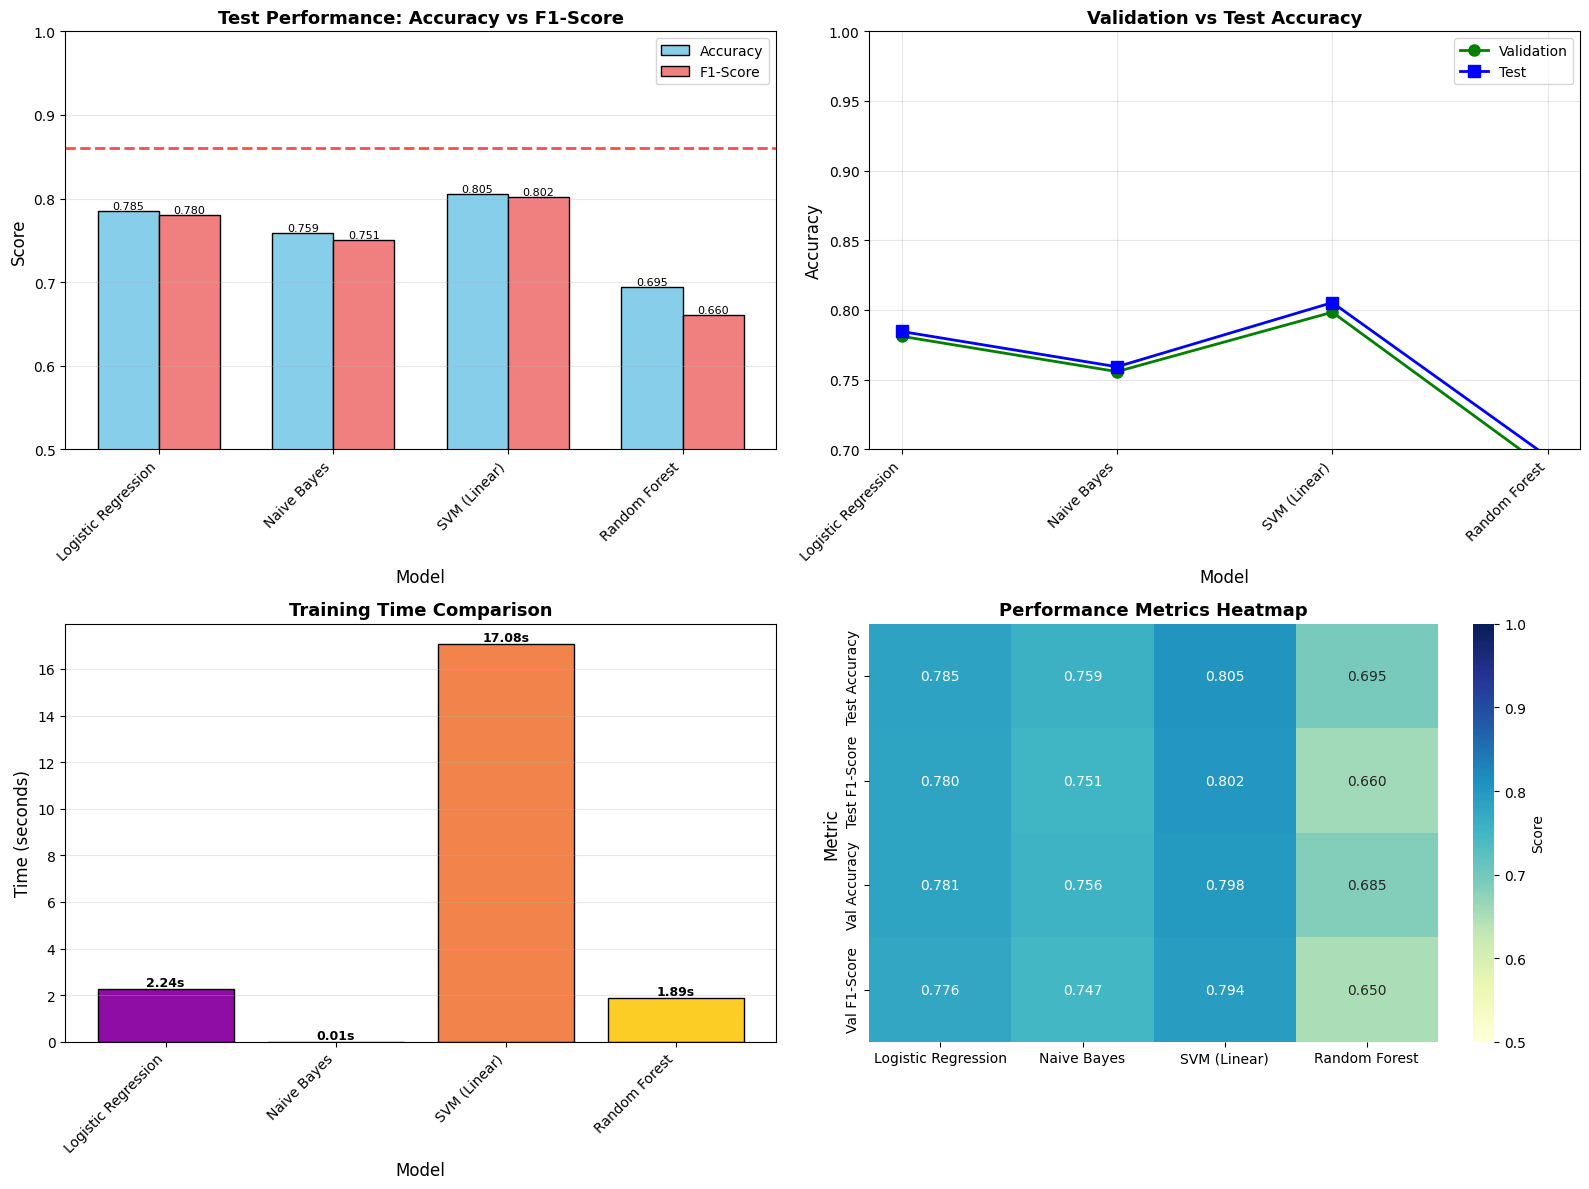


🏆 Best ML Model: SVM (Linear)
   Test Accuracy: 0.8053
   Test F1-Score: 0.8020


In [ ]:
# ============================================================================
# VISUALIZATION: ML Model Comparison
# ============================================================================
print("="*70)
print("MACHINE LEARNING MODELS COMPARISON")
print("="*70 + "\n")

# Create comparison dataframe
ml_comparison_df = pd.DataFrame({
    'Model': list(ml_results.keys()),
    'Val Accuracy': [ml_results[m]['val_accuracy'] for m in ml_results.keys()],
    'Val F1-Score': [ml_results[m]['val_f1'] for m in ml_results.keys()],
    'Test Accuracy': [ml_results[m]['test_accuracy'] for m in ml_results.keys()],
    'Test F1-Score': [ml_results[m]['test_f1'] for m in ml_results.keys()],
    'Train Time (s)': [ml_results[m]['train_time'] for m in ml_results.keys()]
})

print(ml_comparison_df.to_string(index=False))

# Visualization: Model Performance Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Test Accuracy & F1 Comparison
x = np.arange(len(ml_comparison_df))
width = 0.35

bars1 = axes[0, 0].bar(x - width/2, ml_comparison_df['Test Accuracy'], width,
                       label='Accuracy', color='skyblue', edgecolor='black')
bars2 = axes[0, 0].bar(x + width/2, ml_comparison_df['Test F1-Score'], width,
                       label='F1-Score', color='lightcoral', edgecolor='black')

axes[0, 0].set_xlabel('Model', fontsize=12)
axes[0, 0].set_ylabel('Score', fontsize=12)
axes[0, 0].set_title('Test Performance: Accuracy vs F1-Score', fontsize=13, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(ml_comparison_df['Model'], rotation=45, ha='right', fontsize=10)
axes[0, 0].legend()
axes[0, 0].set_ylim([0.5, 1.0])
axes[0, 0].axhline(y=0.86, color='red', linestyle='--', linewidth=2, label='Target (86%)', alpha=0.7)
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# Plot 2: Validation vs Test Accuracy
axes[0, 1].plot(ml_comparison_df['Model'], ml_comparison_df['Val Accuracy'],
               marker='o', label='Validation', linewidth=2, markersize=8, color='green')
axes[0, 1].plot(ml_comparison_df['Model'], ml_comparison_df['Test Accuracy'],
               marker='s', label='Test', linewidth=2, markersize=8, color='blue')
axes[0, 1].set_xlabel('Model', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].set_title('Validation vs Test Accuracy', fontsize=13, fontweight='bold')
axes[0, 1].set_xticklabels(ml_comparison_df['Model'], rotation=45, ha='right', fontsize=10)
axes[0, 1].legend()
axes[0, 1].set_ylim([0.7, 1.0])
axes[0, 1].grid(alpha=0.3)

# Plot 3: Training Time Comparison
bars = axes[1, 0].bar(ml_comparison_df['Model'], ml_comparison_df['Train Time (s)'],
                     color=plt.cm.plasma(np.linspace(0.3, 0.9, len(ml_comparison_df))),
                     edgecolor='black')
axes[1, 0].set_xlabel('Model', fontsize=12)
axes[1, 0].set_ylabel('Time (seconds)', fontsize=12)
axes[1, 0].set_title('Training Time Comparison', fontsize=13, fontweight='bold')
axes[1, 0].set_xticklabels(ml_comparison_df['Model'], rotation=45, ha='right', fontsize=10)
axes[1, 0].grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}s', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 4: Heatmap of all metrics
metrics_for_heatmap = ml_comparison_df.set_index('Model')[['Test Accuracy', 'Test F1-Score',
                                                            'Val Accuracy', 'Val F1-Score']].T
sns.heatmap(metrics_for_heatmap, annot=True, fmt='.3f', cmap='YlGnBu',
           ax=axes[1, 1], cbar_kws={'label': 'Score'}, vmin=0.5, vmax=1.0)
axes[1, 1].set_title('Performance Metrics Heatmap', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylabel('Metric', fontsize=12)

plt.tight_layout()
plt.show()

# Find best ML model
best_ml_model_name = ml_comparison_df.loc[ml_comparison_df['Test F1-Score'].idxmax(), 'Model']
print(f"\n🏆 Best ML Model: {best_ml_model_name}")
print(f"   Test Accuracy: {ml_results[best_ml_model_name]['test_accuracy']:.4f}")
print(f"   Test F1-Score: {ml_results[best_ml_model_name]['test_f1']:.4f}")



CONFUSION MATRICES FOR ML MODELS



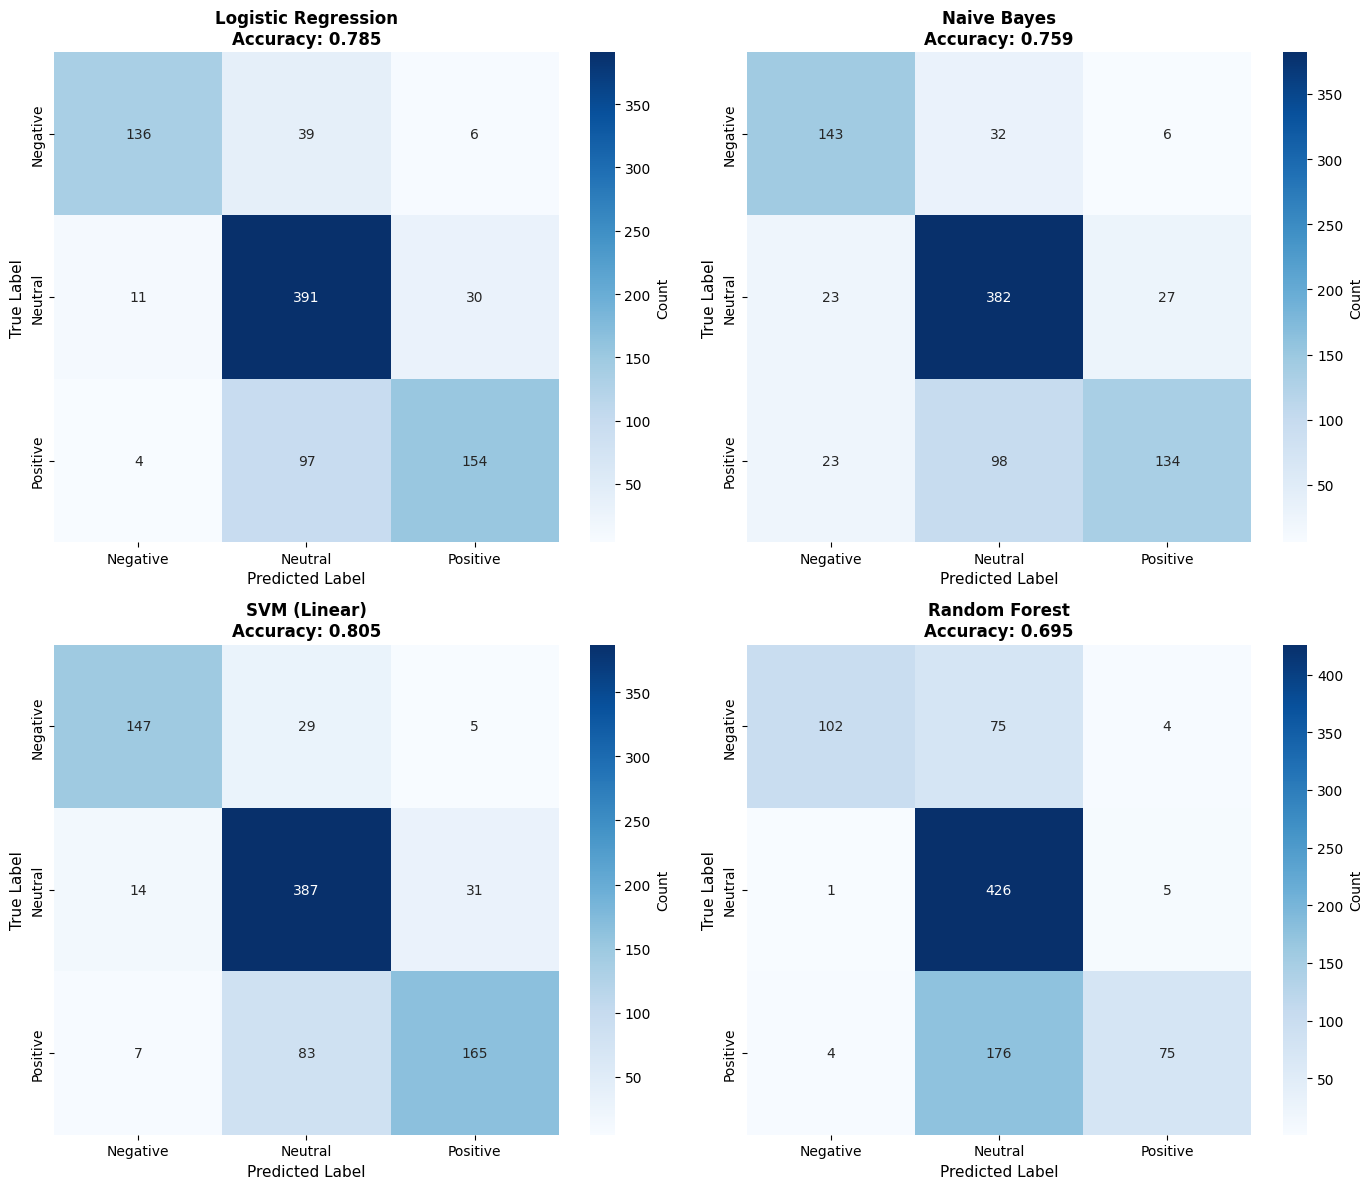


Detailed Classification Report for SVM (Linear):
              precision    recall  f1-score   support

    Negative     0.8750    0.8122    0.8424       181
     Neutral     0.7756    0.8958    0.8314       432
    Positive     0.8209    0.6471    0.7237       255

    accuracy                         0.8053       868
   macro avg     0.8238    0.7850    0.7992       868
weighted avg     0.8096    0.8053    0.8020       868


COMPUTING CLASS WEIGHTS FOR BALANCED TRAINING

Calculated Class Weights:
  Negative (class 0): 1.5957
  Neutral  (class 1): 0.6700
  Positive (class 2): 1.1354

✓ Class weights will be applied during transformer training
  This ensures the model learns all sentiments equally!


In [ ]:
# ============================================================================
# CELL 10: ML Model Confusion Matrices
# ============================================================================
print("\n" + "="*70)
print("CONFUSION MATRICES FOR ML MODELS")
print("="*70 + "\n")

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, (name, results) in enumerate(ml_results.items()):
    cm = confusion_matrix(y_test, results['predictions'])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
               xticklabels=['Negative', 'Neutral', 'Positive'],
               yticklabels=['Negative', 'Neutral', 'Positive'],
               cbar_kws={'label': 'Count'})
    axes[idx].set_title(f'{name}\nAccuracy: {results["test_accuracy"]:.3f}',
                       fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=11)
    axes[idx].set_xlabel('Predicted Label', fontsize=11)

plt.tight_layout()
plt.show()

# Detailed report for best model
print(f"\nDetailed Classification Report for {best_ml_model_name}:")
print("="*70)
print(classification_report(y_test, ml_results[best_ml_model_name]['predictions'],
                          target_names=['Negative', 'Neutral', 'Positive'],
                          digits=4))

# ============================================================================
# CELL 11: Compute Class Weights for Transformer
# ============================================================================
print("\n" + "="*70)
print("COMPUTING CLASS WEIGHTS FOR BALANCED TRAINING")
print("="*70 + "\n")

# Calculate class weights to handle any remaining imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Calculated Class Weights:")
for i, (label, weight) in enumerate(class_weights_dict.items()):
    sentiment = ['Negative', 'Neutral', 'Positive'][i]
    print(f"  {sentiment:8s} (class {label}): {weight:.4f}")

# Convert to tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

print("\n✓ Class weights will be applied during transformer training")
print("  This ensures the model learns all sentiments equally!")


In [ ]:
# ============================================================================
# CELL 12: Prepare Dataset for Transformer Training
# ============================================================================
from datasets import Dataset, DatasetDict

train_data = {'text': X_train.tolist(), 'label': y_train.tolist()}
val_data = {'text': X_val.tolist(), 'label': y_val.tolist()}
test_data = {'text': X_test.tolist(), 'label': y_test.tolist()}

train_dataset = Dataset.from_dict(train_data)
val_dataset = Dataset.from_dict(val_data)
test_dataset = Dataset.from_dict(test_data)

print(f"✓ Datasets prepared")


✓ Datasets prepared


In [ ]:
# ============================================================================
# CELL 9: Load FinBERT and Tokenizer
# ============================================================================
print("\n=== Loading FinBERT Model ===\n")

model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load model with custom configuration
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    ignore_mismatched_sizes=True,
    problem_type="single_label_classification"
)

print("✓ FinBERT loaded successfully!")



=== Loading FinBERT Model ===



tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

✓ FinBERT loaded successfully!


In [ ]:
# ============================================================================
# CELL 10: Enhanced Tokenization
# ============================================================================
def tokenize_function(examples):
    """Enhanced tokenization with proper padding"""
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128,  # Financial sentences are usually shorter
        return_tensors=None
    )

print("Tokenizing datasets...")
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)
print("✓ Tokenization completed!")


Tokenizing datasets...


Map:   0%|          | 0/4050 [00:00<?, ? examples/s]

Map:   0%|          | 0/868 [00:00<?, ? examples/s]

Map:   0%|          | 0/868 [00:00<?, ? examples/s]

✓ Tokenization completed!


In [ ]:
# ============================================================================
# CELL 11: Custom Trainer with Class Weights
# ============================================================================
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=0):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Apply class weights
        if self.class_weights is not None:
            weights = self.class_weights.to(logits.device)
            loss_fct = nn.CrossEntropyLoss(weight=weights)
        else:
            loss_fct = nn.CrossEntropyLoss()

        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

print("✓ Custom trainer with class weights initialized!")

✓ Custom trainer with class weights initialized!


In [ ]:
# ============================================================================
# CELL 12: Optimized Training Configuration
# ============================================================================
print("\n=== Setting Up Training Configuration ===\n")

training_args = TrainingArguments(
    output_dir='./results',

    # Training hyperparameters
    num_train_epochs=5,  # Increased from 3
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,

    # Optimizer settings
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,  # Warm up 10% of steps

    # Learning rate scheduler
    lr_scheduler_type='cosine',  # Cosine annealing

    # Evaluation and logging
    eval_strategy='steps',
    eval_steps=100,  # Evaluate every 100 steps
    save_strategy='steps',
    save_steps=100,
    logging_steps=50,

    # Model selection
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,

    # Performance
    fp16=True,  # Mixed precision training
    dataloader_num_workers=2,

    # Regularization
    max_grad_norm=1.0,

    # Other
    report_to='none',
    seed=42,
    save_total_limit=2,  # Keep only 2 best checkpoints
)

# Metrics computation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted', zero_division=0
    )

    # Per-class metrics
    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
        labels, predictions, average=None, zero_division=0
    )

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'f1_negative': f1_per_class[0],
        'f1_neutral': f1_per_class[1],
        'f1_positive': f1_per_class[2],
    }

# Early stopping callback
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3,  # Stop if no improvement for 3 evaluations
    early_stopping_threshold=0.001
)

# Initialize trainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping],
    class_weights=class_weights_tensor
)

print("✓ Training configuration completed!")
print(f"\nTraining parameters:")
print(f"  - Epochs: {training_args.num_train_epochs}")
print(f"  - Batch size: {training_args.per_device_train_batch_size}")
print(f"  - Learning rate: {training_args.learning_rate}")
print(f"  - LR scheduler: {training_args.lr_scheduler_type}")
print(f"  - Warmup ratio: {training_args.warmup_ratio}")
print(f"  - Mixed precision: {training_args.fp16}")



=== Setting Up Training Configuration ===

✓ Training configuration completed!

Training parameters:
  - Epochs: 5
  - Batch size: 16
  - Learning rate: 2e-05
  - LR scheduler: SchedulerType.COSINE
  - Warmup ratio: 0.1
  - Mixed precision: True


In [ ]:
# ============================================================================
# CELL 13: Train the Model
# ============================================================================
print("\n" + "="*70)
print("TRAINING ENHANCED FINBERT MODEL")
print("="*70)
print("\nThis will take approximately 20-30 minutes...")
print("You can monitor the progress below.\n")

# Train
train_result = trainer.train()

print("\n✓ Training completed!")
print(f"\nTraining metrics:")
print(f"  - Final loss: {train_result.training_loss:.4f}")



TRAINING ENHANCED FINBERT MODEL

This will take approximately 20-30 minutes...
You can monitor the progress below.



Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Negative,F1 Neutral,F1 Positive
100,1.015600,0.640906,0.738479,0.737067,0.738479,0.726874,0.687651,0.853982,0.539379
200,0.455400,0.361608,0.835253,0.859586,0.835253,0.835815,0.874680,0.836601,0.806897
300,0.311500,0.327077,0.862903,0.873148,0.862903,0.864409,0.896175,0.876847,0.820789
400,0.207500,0.324435,0.888249,0.887662,0.888249,0.887807,0.920981,0.904488,0.836000
500,0.257900,0.321115,0.887097,0.886538,0.887097,0.885574,0.931579,0.902635,0.824017
600,0.106200,0.368645,0.895161,0.896584,0.895161,0.895595,0.942149,0.905882,0.845124
700,0.114700,0.415235,0.887097,0.889929,0.887097,0.887930,0.923944,0.901176,0.839925
800,0.059900,0.381133,0.898618,0.899191,0.898618,0.898818,0.947658,0.906542,0.851064
900,0.032200,0.399691,0.895161,0.898785,0.895161,0.896010,0.938889,0.904762,0.850746
1000,0.063900,0.422030,0.899770,0.900742,0.899770,0.900111,0.941828,0.909942,0.853846



✓ Training completed!

Training metrics:
  - Final loss: 0.2860


In [ ]:
# ============================================================================
# CELL 14: Evaluate on Validation Set
# ============================================================================
print("\n=== Validation Set Evaluation ===\n")

val_results = trainer.evaluate(tokenized_val)

print("Validation Results:")
for key, value in val_results.items():
    if key.startswith('eval_'):
        metric_name = key.replace('eval_', '').upper()
        print(f"  {metric_name}: {value:.4f}")



=== Validation Set Evaluation ===



Validation Results:
  LOSS: 0.4220
  ACCURACY: 0.8998
  PRECISION: 0.9007
  RECALL: 0.8998
  F1: 0.9001
  F1_NEGATIVE: 0.9418
  F1_NEUTRAL: 0.9099
  F1_POSITIVE: 0.8538
  RUNTIME: 2.2468
  SAMPLES_PER_SECOND: 386.3350
  STEPS_PER_SECOND: 24.4800



=== Test Set Evaluation ===



Test Results:
  LOSS: 0.4612
  ACCURACY: 0.8756
  PRECISION: 0.8779
  RECALL: 0.8756
  F1: 0.8761
  F1_NEGATIVE: 0.9121
  F1_NEUTRAL: 0.8836
  F1_POSITIVE: 0.8377
  RUNTIME: 2.2184
  SAMPLES_PER_SECOND: 391.2670
  STEPS_PER_SECOND: 24.7920

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative     0.9071    0.9171    0.9121       181
     Neutral     0.9073    0.8611    0.8836       432
    Positive     0.8073    0.8706    0.8377       255

    accuracy                         0.8756       868
   macro avg     0.8739    0.8829    0.8778       868
weighted avg     0.8779    0.8756    0.8761       868



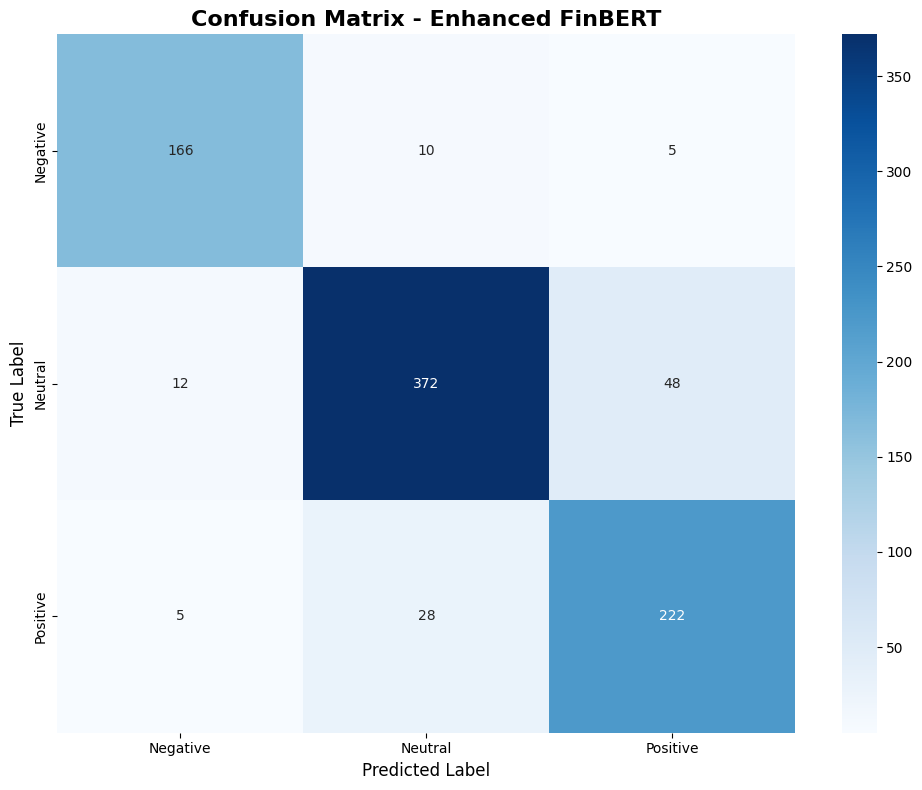

In [ ]:
# ============================================================================
# CELL 15: Evaluate on Test Set
# ============================================================================
print("\n=== Test Set Evaluation ===\n")

test_results = trainer.evaluate(tokenized_test)

print("Test Results:")
for key, value in test_results.items():
    if key.startswith('eval_'):
        metric_name = key.replace('eval_', '').upper()
        print(f"  {metric_name}: {value:.4f}")

# Get predictions
predictions = trainer.predict(tokenized_test)
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(
    y_test,
    predicted_labels,
    target_names=['Negative', 'Neutral', 'Positive'],
    digits=4
))

# Confusion Matrix
cm = confusion_matrix(y_test, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix - Enhanced FinBERT', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()



=== Training History ===



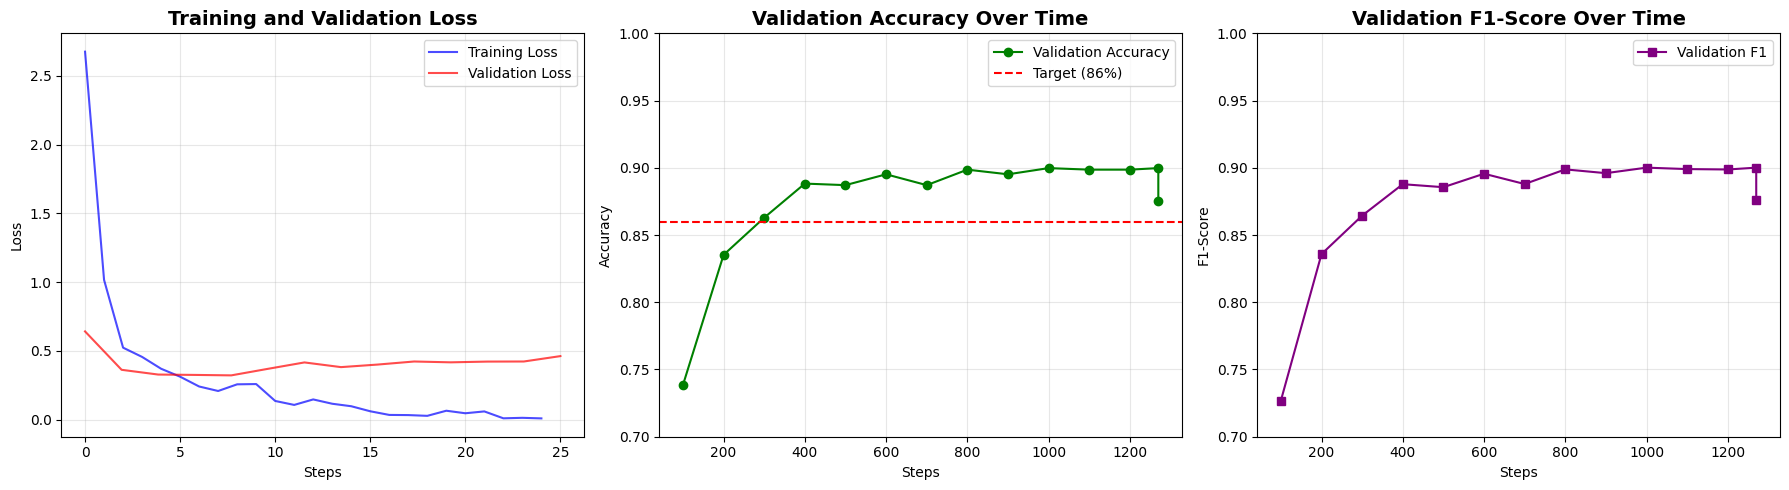

In [ ]:
# ============================================================================
# CELL 16: Training History Visualization
# ============================================================================
print("\n=== Training History ===\n")

# Get training logs
logs = trainer.state.log_history

# Extract metrics
train_loss = []
eval_loss = []
eval_accuracy = []
eval_f1 = []
steps = []

for log in logs:
    if 'loss' in log and 'eval_loss' not in log:
        train_loss.append(log['loss'])
    if 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])
        eval_accuracy.append(log.get('eval_accuracy', 0))
        eval_f1.append(log.get('eval_f1', 0))
        steps.append(log['step'])

# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(train_loss, label='Training Loss', color='blue', alpha=0.7)
if eval_loss:
    axes[0].plot(np.linspace(0, len(train_loss), len(eval_loss)), eval_loss,
                 label='Validation Loss', color='red', alpha=0.7)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy
if eval_accuracy:
    axes[1].plot(steps, eval_accuracy, label='Validation Accuracy',
                 color='green', marker='o')
    axes[1].axhline(y=0.86, color='red', linestyle='--', label='Target (86%)')
    axes[1].set_title('Validation Accuracy Over Time', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Steps')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_ylim([0.7, 1.0])
    axes[1].legend()
    axes[1].grid(alpha=0.3)

# F1 Score
if eval_f1:
    axes[2].plot(steps, eval_f1, label='Validation F1',
                 color='purple', marker='s')
    axes[2].set_title('Validation F1-Score Over Time', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Steps')
    axes[2].set_ylabel('F1-Score')
    axes[2].set_ylim([0.7, 1.0])
    axes[2].legend()
    axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()



=== Per-Class Performance Analysis ===

   Class  Precision   Recall  F1-Score  Support
Negative   0.907104 0.917127  0.912088      181
 Neutral   0.907317 0.861111  0.883610      432
Positive   0.807273 0.870588  0.837736      255


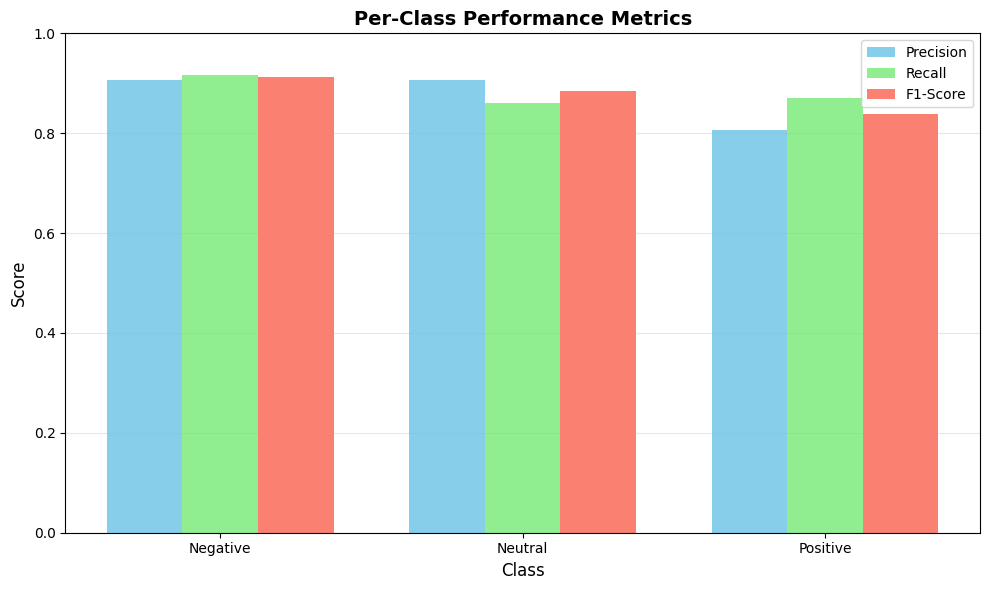

In [ ]:
# ============================================================================
# CELL 17: Per-Class Performance Analysis
# ============================================================================
print("\n=== Per-Class Performance Analysis ===\n")

# Calculate per-class metrics
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    y_test, predicted_labels, average=None
)

# Create DataFrame
class_performance = pd.DataFrame({
    'Class': ['Negative', 'Neutral', 'Positive'],
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print(class_performance.to_string(index=False))

# Visualize per-class metrics
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(class_performance))
width = 0.25

bars1 = ax.bar(x - width, class_performance['Precision'], width,
               label='Precision', color='skyblue')
bars2 = ax.bar(x, class_performance['Recall'], width,
               label='Recall', color='lightgreen')
bars3 = ax.bar(x + width, class_performance['F1-Score'], width,
               label='F1-Score', color='salmon')

ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_performance['Class'])
ax.legend()
ax.set_ylim([0, 1.0])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# CELL 18: Error Analysis
# ============================================================================
print("\n=== Error Analysis ===\n")

# Find misclassified samples
misclassified_indices = np.where(y_test.values != predicted_labels)[0]
print(f"Total misclassified: {len(misclassified_indices)} out of {len(y_test)}")
print(f"Accuracy: {(len(y_test) - len(misclassified_indices)) / len(y_test) * 100:.2f}%")

# Analyze misclassification patterns
misclass_patterns = pd.DataFrame({
    'True Label': [y_test.values[i] for i in misclassified_indices],
    'Predicted Label': [predicted_labels[i] for i in misclassified_indices]
})

print("\nMisclassification patterns:")
print(pd.crosstab(
    misclass_patterns['True Label'],
    misclass_patterns['Predicted Label'],
    rownames=['True'],
    colnames=['Predicted']
))

# Show some misclassified examples
print("\nSample misclassified texts:")
label_names = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

for i in misclassified_indices[:5]:
    true_label = y_test.values[i]
    pred_label = predicted_labels[i]
    text = X_test.values[i]

    print(f"\nText: {text[:150]}...")
    print(f"True: {label_names[true_label]} | Predicted: {label_names[pred_label]}")



=== Error Analysis ===

Total misclassified: 108 out of 868
Accuracy: 87.56%

Misclassification patterns:
Predicted   0   1   2
True                 
0           0  10   5
1          12   0  48
2           5  28   0

Sample misclassified texts:

Text: Nokia said it still expects to sell 150 more million Symbian devices in years to come , giving an indication of how it expects the Phone 7 handoff to ...
True: Neutral | Predicted: Positive

Text: The merger between the two telecoms operators was expected to result in the world 's fourth largest telecoms operator ....
True: Neutral | Predicted: Positive

Text: 4 January 2011 - Finnish media company Alma Media Corporation HEL : ALN1V said today its online recruitment service Monster Oy will partner with local...
True: Neutral | Predicted: Positive

Text: The company also expects to sell its products in other Russian region ....
True: Positive | Predicted: Neutral

Text: The effect of the savings will be noticeable as of the beginning of 2

In [ ]:
# ============================================================================
# CELL 19: Save the Enhanced Model
# ============================================================================
print("\n=== Saving Enhanced Model ===\n")

# Save model and tokenizer
output_dir = './enhanced_finbert_model'
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"✓ Model saved to '{output_dir}/'")

# Save training configuration
import json

config_info = {
    'model_name': model_name,
    'num_epochs': training_args.num_train_epochs,
    'batch_size': training_args.per_device_train_batch_size,
    'learning_rate': training_args.learning_rate,
    'test_accuracy': float(test_results['eval_accuracy']),
    'test_f1': float(test_results['eval_f1']),
    'class_weights': class_weights_dict,
    'total_samples': len(df),
    'train_samples': len(X_train),
    'val_samples': len(X_val),
    'test_samples': len(X_test)
}

with open(f'{output_dir}/training_config.json', 'w') as f:
    json.dump(config_info, f, indent=4)

print("✓ Training configuration saved")



=== Saving Enhanced Model ===

✓ Model saved to './enhanced_finbert_model/'
✓ Training configuration saved


In [ ]:
# ============================================================================
# CELL 20: Final Summary Report
# ============================================================================
print("\n" + "="*70)
print("FINAL PERFORMANCE SUMMARY")
print("="*70)

print(f"\n📊 Dataset Statistics:")
print(f"  Total samples: {len(df)}")
print(f"  Training: {len(X_train)} | Validation: {len(X_val)} | Test: {len(X_test)}")

print(f"\n🎯 Model Performance:")
print(f"  Test Accuracy: {test_results['eval_accuracy']*100:.2f}%")
print(f"  Test F1-Score: {test_results['eval_f1']:.4f}")
print(f"  Test Precision: {test_results['eval_precision']:.4f}")
print(f"  Test Recall: {test_results['eval_recall']:.4f}")

print(f"\n📈 Training Details:")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Learning Rate: {training_args.learning_rate}")
print(f"  Batch Size: {training_args.per_device_train_batch_size}")
print(f"  LR Scheduler: {training_args.lr_scheduler_type}")

print(f"\n💾 Model Location:")
print(f"  Saved to: {output_dir}/")

# Check if targets are met
target_test_acc = 0.86
actual_test_acc = test_results['eval_accuracy']

print(f"\n✅ Performance Check:")
if actual_test_acc >= target_test_acc:
    print(f"  🎉 SUCCESS! Test accuracy {actual_test_acc*100:.2f}% >= Target {target_test_acc*100:.0f}%")
else:
    diff = (target_test_acc - actual_test_acc) * 100
    print(f"  ⚠️  Test accuracy {actual_test_acc*100:.2f}% (Need {diff:.1f}% more)")
    print(f"\n  💡 Suggestions to improve:")
    print(f"     - Increase training epochs (try 7-10)")
    print(f"     - Add more data augmentation")
    print(f"     - Try different learning rates (1e-5 to 5e-5)")
    print(f"     - Ensemble multiple models")

print(f"\n{'='*70}")
print("✓ TRAINING COMPLETED!")
print(f"{'='*70}\n")

print("Next steps:")
print("1. Download the model folder from Colab")
print("2. Update your Streamlit app to use this model")
print("3. Test with real-world financial texts")


FINAL PERFORMANCE SUMMARY

📊 Dataset Statistics:
  Total samples: 5786
  Training: 4050 | Validation: 868 | Test: 868

🎯 Model Performance:
  Test Accuracy: 87.56%
  Test F1-Score: 0.8761
  Test Precision: 0.8779
  Test Recall: 0.8756

📈 Training Details:
  Epochs: 5
  Learning Rate: 2e-05
  Batch Size: 16
  LR Scheduler: SchedulerType.COSINE

💾 Model Location:
  Saved to: ./enhanced_finbert_model/

✅ Performance Check:
  🎉 SUCCESS! Test accuracy 87.56% >= Target 86%

✓ TRAINING COMPLETED!

Next steps:
1. Download the model folder from Colab
2. Update your Streamlit app to use this model
3. Test with real-world financial texts


In [ ]:
!zip -r enhanced_finbert_model.zip enhanced_finbert_model


  adding: enhanced_finbert_model/ (stored 0%)
  adding: enhanced_finbert_model/training_config.json (deflated 43%)
  adding: enhanced_finbert_model/tokenizer.json (deflated 71%)
  adding: enhanced_finbert_model/special_tokens_map.json (deflated 42%)
  adding: enhanced_finbert_model/model.safetensors (deflated 7%)
  adding: enhanced_finbert_model/config.json (deflated 51%)
  adding: enhanced_finbert_model/tokenizer_config.json (deflated 75%)
  adding: enhanced_finbert_model/training_args.bin (deflated 53%)
  adding: enhanced_finbert_model/vocab.txt (deflated 53%)


In [ ]:
from google.colab import files
files.download('enhanced_finbert_model.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>